In [ ]:
''' This is Research Project titled ML Algorithms for Alberta Forest Occurence Prediction.
    This is the 8th Engineering Research Project, and is hereby delcared as
                            
                            Project Christopher
    
    Version 2.0 - Random Forest Classifier - Selected Features
    Data Source: European Space Agency - ERA5
                 Government of Alberta - Historical Wildfire registry and Fire Weather Indices
                 Natural Resources Canada - Vegetation Classification of Canada
    
    AI Diederik - Hongik Ingan, For the Benefits of All Mankind
'''

In [1]:
import sys
import os
import pandas as pd

from sklearn import set_config
set_config(transform_output = "pandas")

# Custom utils
PROJECT_ROOT = '../'
MODEL_PATH = os.path.join(PROJECT_ROOT,'models','RF')
sys.path.append(PROJECT_ROOT)
from scripts.data_utils import load_downsampled_df, load_full_df, get_train_validation_df, test_train_validation_split
from models.RF.functions import get_preprocess_pipeline

In [2]:
# Load and split data

main_df = load_downsampled_df(PROJECT_ROOT)
validation_df, test_train_df = get_train_validation_df(main_df)
X_train, X_test, X_validation, y_train, y_test, y_validation = test_train_validation_split(validation_df,test_train_df)
del main_df

In [3]:
# Create and fit pipeline

Data_pipeline = get_preprocess_pipeline(X_train)
X_train_processed = Data_pipeline.fit_transform(X_train)
X_test_processed = Data_pipeline.transform(X_test)

In [ ]:
## Final Classifier
from sklearn.ensemble import RandomForestClassifier

params = {'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

RF_clf = RandomForestClassifier(**params)
RF_clf.fit(X_train_processed,y_train)

In [ ]:
## Save final model and pipeline
from joblib import dump

dump(Data_pipeline,os.path.join(MODEL_PATH,'RF_preprocess_pipeline.joblib'))
dump(RF_clf,os.path.join(MODEL_PATH,'RF_model.joblib'))

**Evaluation**

In [11]:
from scripts.Visualization_functions import generate_visualizations, print_metrics, plot_roc_curve

In [8]:
# Get the validation dataset
main_df = load_full_df(PROJECT_ROOT)
validation_df, test_train_df = get_train_validation_df(main_df)
_, X_test, X_validation, _, y_test, y_validation = test_train_validation_split(validation_df,test_train_df)

In [4]:
## Load preprocess pipeline and model ##
from joblib import load

Data_pipeline = load(os.path.join(MODEL_PATH,'RF_preprocess_pipeline.joblib'))
RF_clf = load(os.path.join(MODEL_PATH,'RF_model.joblib'))

In [10]:
# Get Predictions
X_val_processed = Data_pipeline.transform(X_validation)
y_pred_proba = RF_clf.predict_proba(X_val_processed)[:,1]

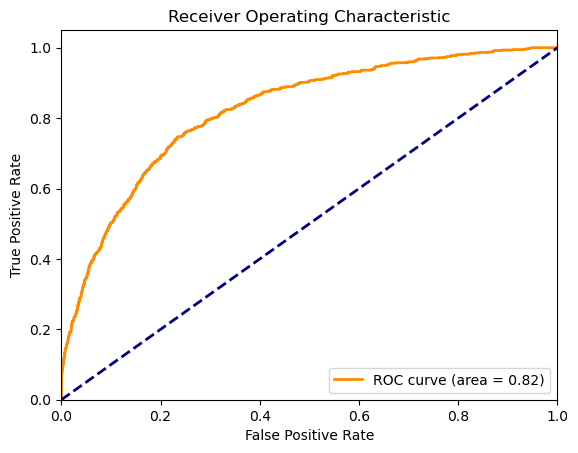

In [12]:
plot_roc_curve(y_validation, y_pred_proba)

In [15]:
thresh = 0.5
y_val_pred = (y_pred_proba > thresh).astype(int)
generate_visualizations(X_val_processed,y_val_pred,y_validation,main_df,os.path.join(MODEL_PATH,"RF_Visuals"))

In [15]:
print_metrics(y_validation,y_val_pred)

Validation set accuracy: 0.994139856185307
f1 score:  0.10951979780960404
Precision: 0.14942528735632185
Recall: 0.08643617021276596


In [16]:
# Save validation probabilities
import numpy as np

np.save(os.path.join(MODEL_PATH,'RF_y_val_proba.npy'),y_pred_proba)

**Hyperparameter and Model Tuning**

In [4]:
X_train.keys()

Index(['date', 'latitude', 'longitude', 'high_vegetation_cover',
       'leaf_area_index_high_vegetation', 'leaf_area_index_low_vegetation',
       'low_vegetation_cover', 'slope_of_sub_gridscale_orography',
       'type_of_high_vegetation', 'type_of_low_vegetation',
       '24hr_accumulated_precipitation', '24hr_max_temperature',
       'global_noon_LST_2m_temperature', 'global_noon_LST_relative_humidity',
       'global_noon_LST_wind_speed', 'BUI', 'DC', 'DMC', 'FFMC', 'FWI',
       'fire_count_past_3Days', 'fire_count_past_7Days',
       'fire_count_past_10Days', 'fire_count_past_30Days',
       '24hr_max_temperature_1dayLag', '24hr_max_temperature_2dayLag',
       'global_noon_LST_2m_temperature_1dayLag',
       'global_noon_LST_2m_temperature_2dayLag'],
      dtype='object')

In [16]:
## Feature Selection

# SelectKB
from sklearn.feature_selection import SelectKBest, f_classif,chi2
SelectKB_train = SelectKBest(f_classif,k=10)
SelectKB_train.fit(pd.DataFrame(X_train_processed,columns=X_train_processed.columns),y_train)
feature_names=SelectKB_train.get_feature_names_out()
print('Based on the Selected KBest Algorithm, the following 10 features should be selected:')
print(feature_names)

# PCA Analysis
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(X_train_processed)
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_90 = len(total_explained_variance[total_explained_variance >= .90])
n_to_reach_90 = X_train_processed.shape[1] - n_over_90 + 1
print('-------------PCA Analysis----------------')
print("Number of features in the original dataset: {}".format(X_train_processed.shape[1]))
print("Number of features: {}\tTotal Variance Explained: {}".format(n_to_reach_90, total_explained_variance[n_to_reach_90-1]))


Based on the Selected KBest Algorithm, the following 10 features should be selected:
['pass__slope_of_sub_gridscale_orography' 'numeric__DMC'
 'numeric__global_noon_LST_2m_temperature' 'numeric__BUI' 'numeric__FWI'
 'numeric__FFMC' 'numeric__global_noon_LST_relative_humidity'
 'numeric__24hr_max_temperature'
 'numeric__global_noon_LST_2m_temperature_1dayLag'
 'pass__leaf_area_index_high_vegetation']
-------------PCA Analysis----------------
Number of features in the original dataset: 12
Number of features: 5	Total Variance Explained: 0.9101246341622341


In [17]:
# Grid Search 1
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer


# Initialize and train the random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

#F1 scorer
f1 = make_scorer(f1_score , average='macro')

param_grid = {
    'n_estimators': [200,400,800],  # Number of trees in the  forest
    'max_depth': [8,10],
    'max_features': ['sqrt','log2'],
    'min_samples_leaf': [2,5,10],
    'min_samples_split': [5,7]
}

grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring=f1,n_jobs=-1,verbose=1)
grid_search.fit(X_train_processed, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [8, 10], 'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [2, 5, 10],
                         'min_samples_split': [5, 7],
                         'n_estimators': [200, 400, 800]},
             scoring=make_scorer(f1_score, response_method='predict', average=macro),
             verbose=1)

In [19]:
# Grid Search 2
param_grid = {
    'n_estimators': [50,100,150,200],  # Number of trees in the forest
    'max_depth': [4,6,8,10,20,80],
    'max_features': ['sqrt','log2'],
    'min_samples_leaf': [2,5,10],
    'min_samples_split': [5,7,10]
}

grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring=f1,n_jobs=-1,verbose=1)
grid_search.fit(X_train_processed, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print(f"F1 Score: {100*grid_search.best_score_:.2f}%")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters: {'max_depth': 80, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
F1 Score: 79.84%


In [14]:
# Grid Search 3
best_classifier = grid_search.best_estimator_

# Predict on the validation set
y_test_pred = best_classifier.predict(X_test_processed)

# Evaluate the accuracy of the model on the validation set
accuracy = accuracy_score(y_test, y_test_pred)
print("Validation set accuracy:", accuracy)
print('f1 score: ',f1_score(y_test, y_test_pred))

Validation set accuracy: 0.828083911068611
f1 score:  0.6187794049433437


In [18]:
# Save the best model
import joblib

best_classifier = grid_search.best_estimator_

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print(f"F1 Score: {100*grid_search.best_score_:.2f}%")
joblib.dump(best_classifier, os.path.join(MODEL_PATH,"RF_model.joblib"))

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 800}
F1 Score: 68.20%


['./random_forest_R3 2024-04-16.joblib']

C:\Users\Home Office\AppData\Local\Temp\ipykernel_18576\2010776610.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(feature_scores.index)


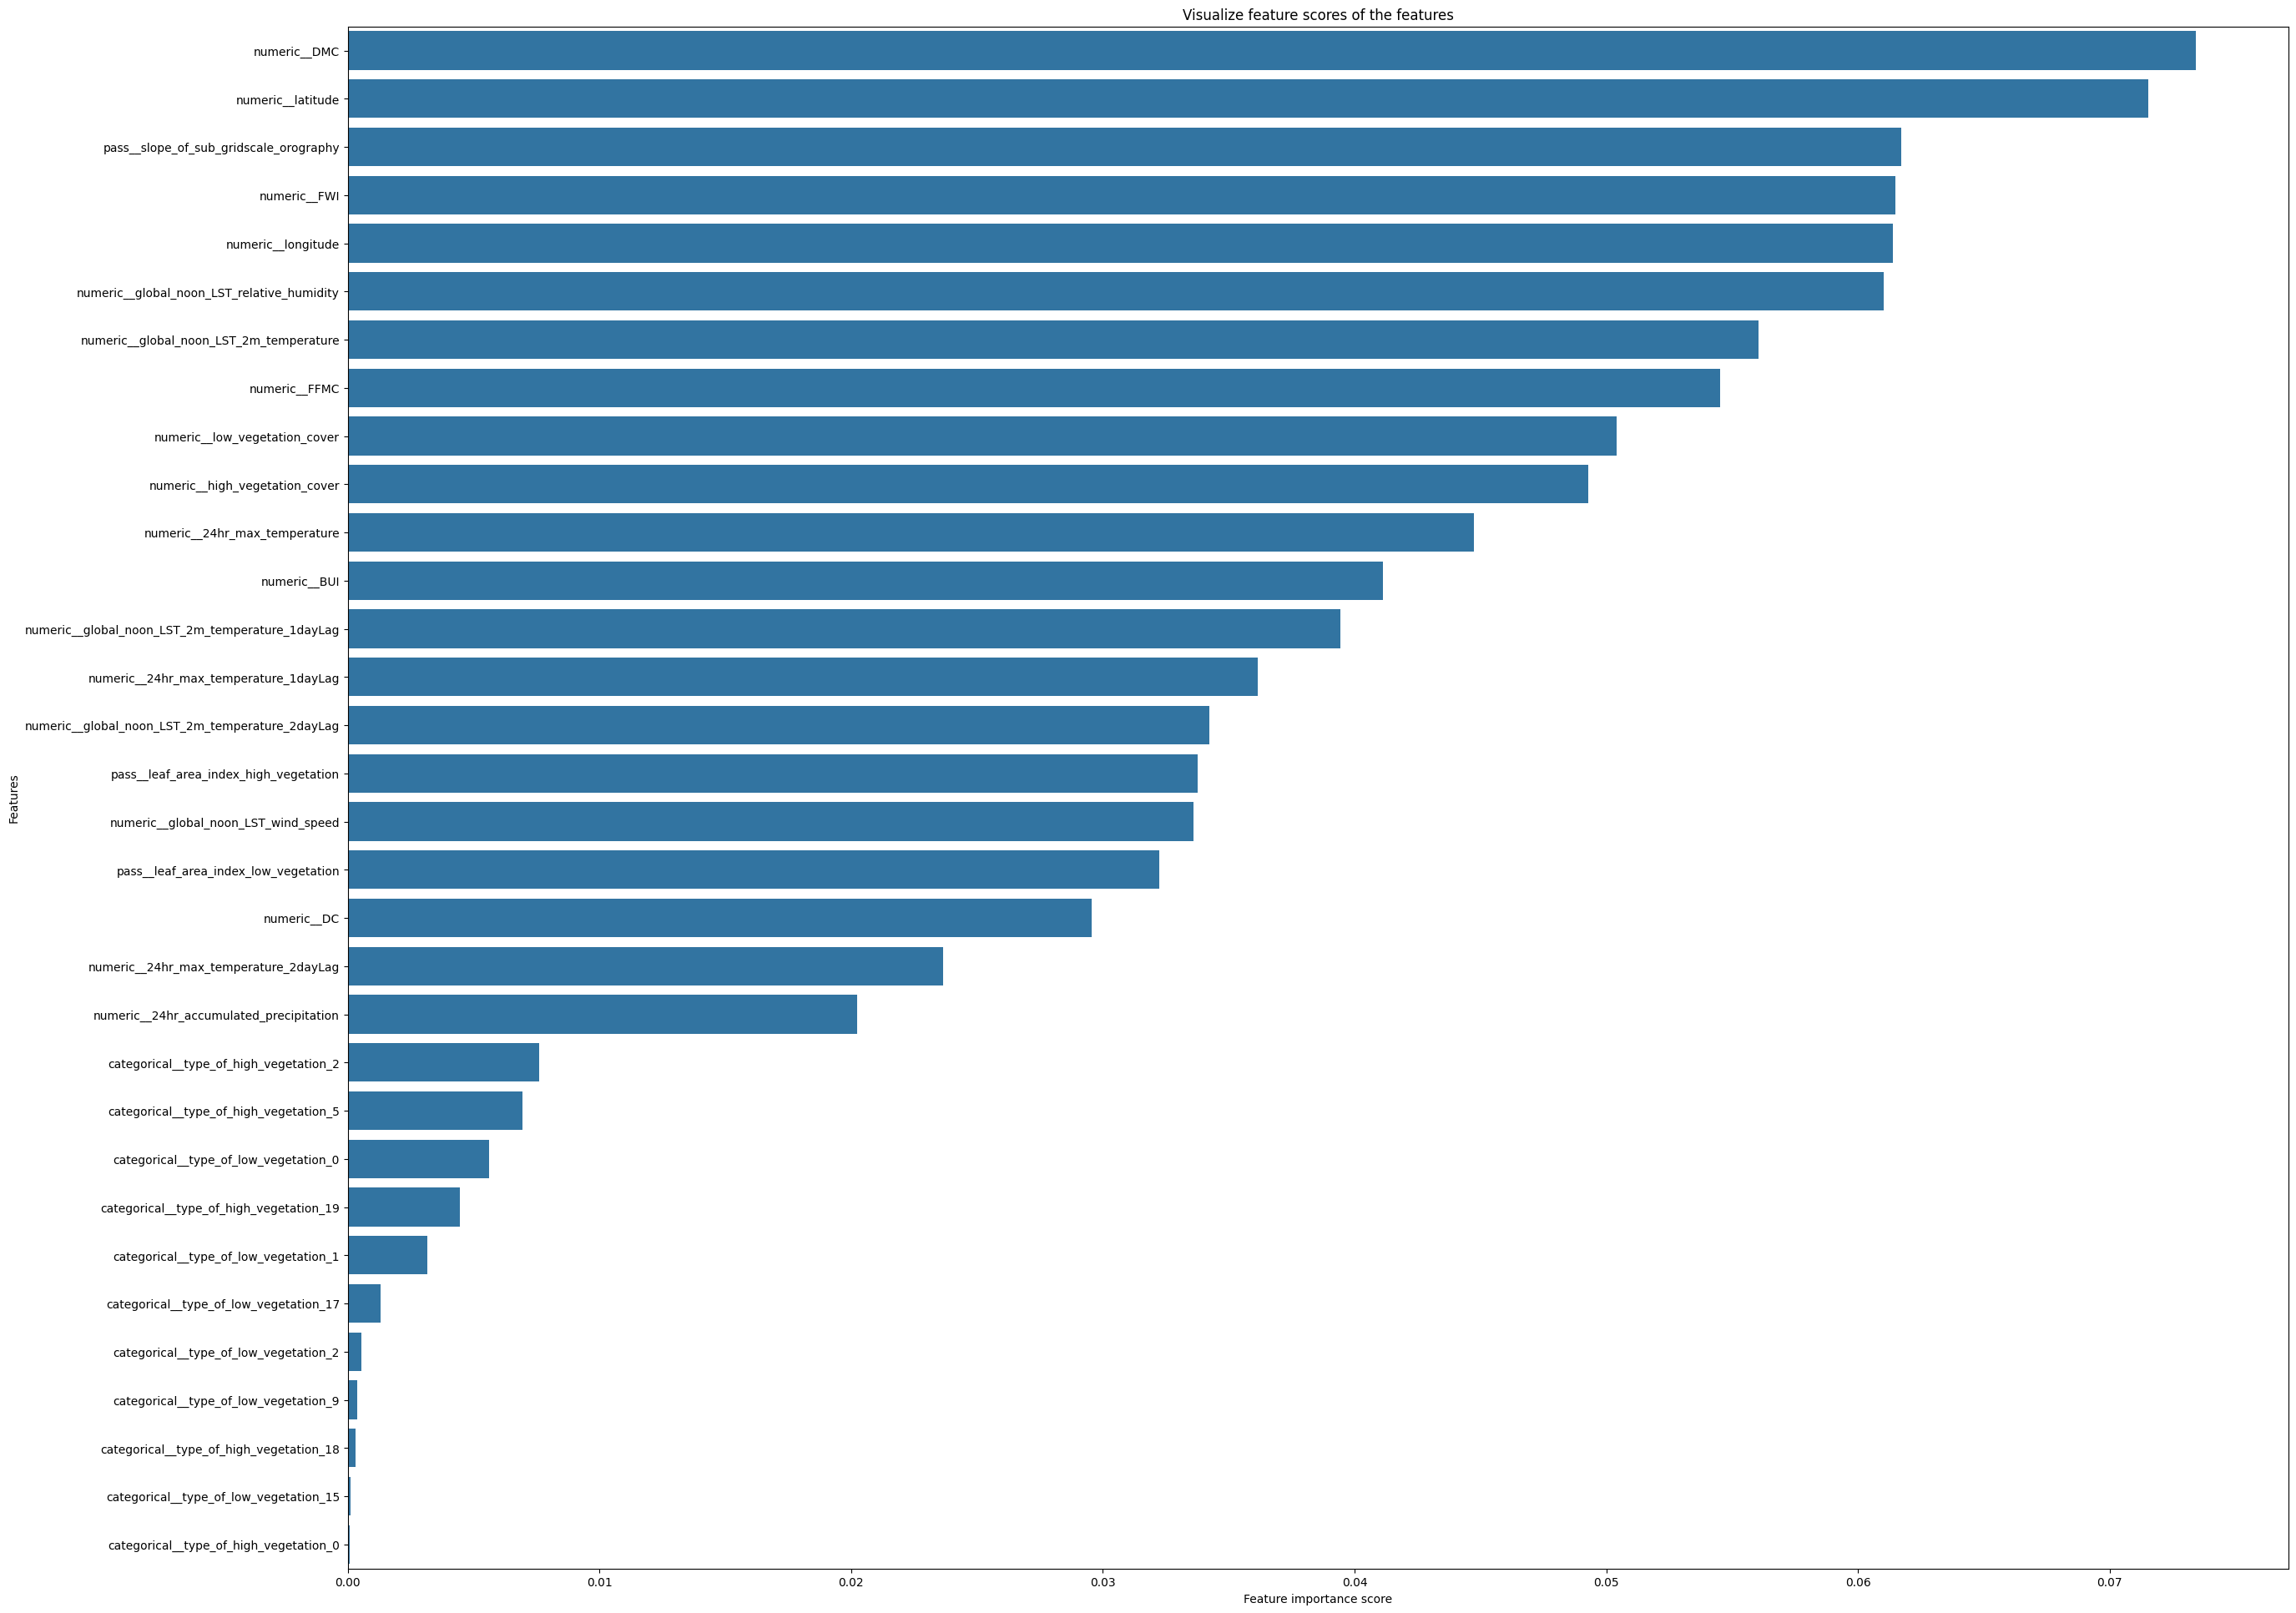

Validation set accuracy: 0.7992170690891705
f1 score:  0.511523082515449


In [22]:
# Get Feature Importance

import seaborn as sns
import matplotlib.pyplot as plt

feature_scores = pd.Series(best_classifier.feature_importances_, index=X_train_processed.columns).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()


# Predict on the validation set
y_test_pred = best_classifier.predict(X_test_processed)

# Evaluate the accuracy of the model on the validation set
accuracy = accuracy_score(y_test, y_test_pred)
print("Validation set accuracy:", accuracy)
print('f1 score: ',f1_score(y_test, y_test_pred))

In [ ]:
feature_scores

numeric__fire_count_past_3Days                     0.252285
numeric__fire_count_past_7Days                     0.193044
numeric__fire_count_past_10Days                    0.168429
numeric__fire_count_past_30Days                    0.126317
numeric__DMC                                       0.025564
numeric__global_noon_LST_2m_temperature            0.022685
numeric__BUI                                       0.020464
numeric__FWI                                       0.019396
numeric__latitude                                  0.017524
numeric__FFMC                                      0.017485
numeric__global_noon_LST_relative_humidity         0.015353
numeric__24hr_max_temperature                      0.012945
numeric__global_noon_LST_2m_temperature_1dayLag    0.012480
pass__leaf_area_index_high_vegetation              0.010740
numeric__global_noon_LST_2m_temperature_2dayLag    0.008820
numeric__high_vegetation_cover                     0.008521
numeric__24hr_max_temperature_1dayLag   